In [27]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [28]:
%matplotlib inline

from session.sessions import selected_009266, selected_008229, selected_009265
from imports import *
from scipy import stats
from scipy import signal
from target import get_spike_counts
from Behavior.behavior import get_idxs_neuro_state, get_idxs_behav_state
from population import unit_response_matrix, activity_at_phase

In [29]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [30]:
def get_positions_relative_to(pos_alo, HD, poi, res_type='polar'):
    """
    pos_allo    2D array of alloentric animal positions X, Y    (shape Nx2)
    HD          vector of HD angles (in rad.) for each pos_allo (shape N)
    poi         point of interest (x, y) relative to which to compute egocentric coords.
    """
    pos_poi = poi - pos_alo
    R = np.linalg.norm(pos_poi, axis=1)  # distance from animal to the POI
    phi_alo = (np.degrees(np.arctan2(pos_poi[:, 1], pos_poi[:, 0])) - HD) % 360  # angle to POI in allocentric frame, in deg.
    phi_ego = phi_alo - np.rad2deg(HD)  # angle to POI in egocentric frame, in deg.
    phi_ego = np.deg2rad(phi_ego)
    
    if res_type == 'polar':
        return np.array([R, phi_ego]).T
    return np.array([np.multiply(R, np.cos(phi_ego)), np.multiply(R, np.sin(phi_ego))]).T

In [31]:
source = '/home/sobolev/nevermind_ag-grothe/AG_Pecka/data/processed/'
source = '/home/sobolev/nevermind/AG_Pecka/data/processed/'

sessions = [s for s in selected_009266.keys()]
#sessions = [s for s in selected_009265.keys()]
#sessions = [s for s in selected_008229.keys()]
sessions.sort()

try:
    sessions.remove('009266_hippoSIT_2023-04-20_15-24-14')
except:
    pass
try:
    sessions.remove('009265_hippoSIT_2023-02-27_10-18-32')
    sessions.remove('009265_hippoSIT_2023-02-27_15-33-46')
except:
    pass

# special for 009265
#sessions = sessions[7:-1]
sessions

['009266_hippoSIT_2023-04-17_17-04-17',
 '009266_hippoSIT_2023-04-18_10-10-37',
 '009266_hippoSIT_2023-04-18_17-03-10',
 '009266_hippoSIT_2023-04-19_10-33-51',
 '009266_hippoSIT_2023-04-20_08-57-39',
 '009266_hippoSIT_2023-04-21_08-43-00',
 '009266_hippoSIT_2023-04-21_13-12-31',
 '009266_hippoSIT_2023-04-24_10-08-11',
 '009266_hippoSIT_2023-04-24_16-56-55',
 '009266_hippoSIT_2023-04-26_08-20-17',
 '009266_hippoSIT_2023-05-02_12-22-14',
 '009266_hippoSIT_2023-05-04_19-47-15',
 '009266_hippoSIT_2023-05-22_09-27-22',
 '009266_hippoSIT_2023-05-23_09-18-05',
 '009266_hippoSIT_2023-05-25_15-55-57',
 '009266_hippoSIT_2023-06-14_08-21-23',
 '009266_hippoSIT_2023-06-19_08-58-35']

## Angle distribution controls

In [32]:
selected = sessions[:]
selected

['009266_hippoSIT_2023-04-17_17-04-17',
 '009266_hippoSIT_2023-04-18_10-10-37',
 '009266_hippoSIT_2023-04-18_17-03-10',
 '009266_hippoSIT_2023-04-19_10-33-51',
 '009266_hippoSIT_2023-04-20_08-57-39',
 '009266_hippoSIT_2023-04-21_08-43-00',
 '009266_hippoSIT_2023-04-21_13-12-31',
 '009266_hippoSIT_2023-04-24_10-08-11',
 '009266_hippoSIT_2023-04-24_16-56-55',
 '009266_hippoSIT_2023-04-26_08-20-17',
 '009266_hippoSIT_2023-05-02_12-22-14',
 '009266_hippoSIT_2023-05-04_19-47-15',
 '009266_hippoSIT_2023-05-22_09-27-22',
 '009266_hippoSIT_2023-05-23_09-18-05',
 '009266_hippoSIT_2023-05-25_15-55-57',
 '009266_hippoSIT_2023-06-14_08-21-23',
 '009266_hippoSIT_2023-06-19_08-58-35']

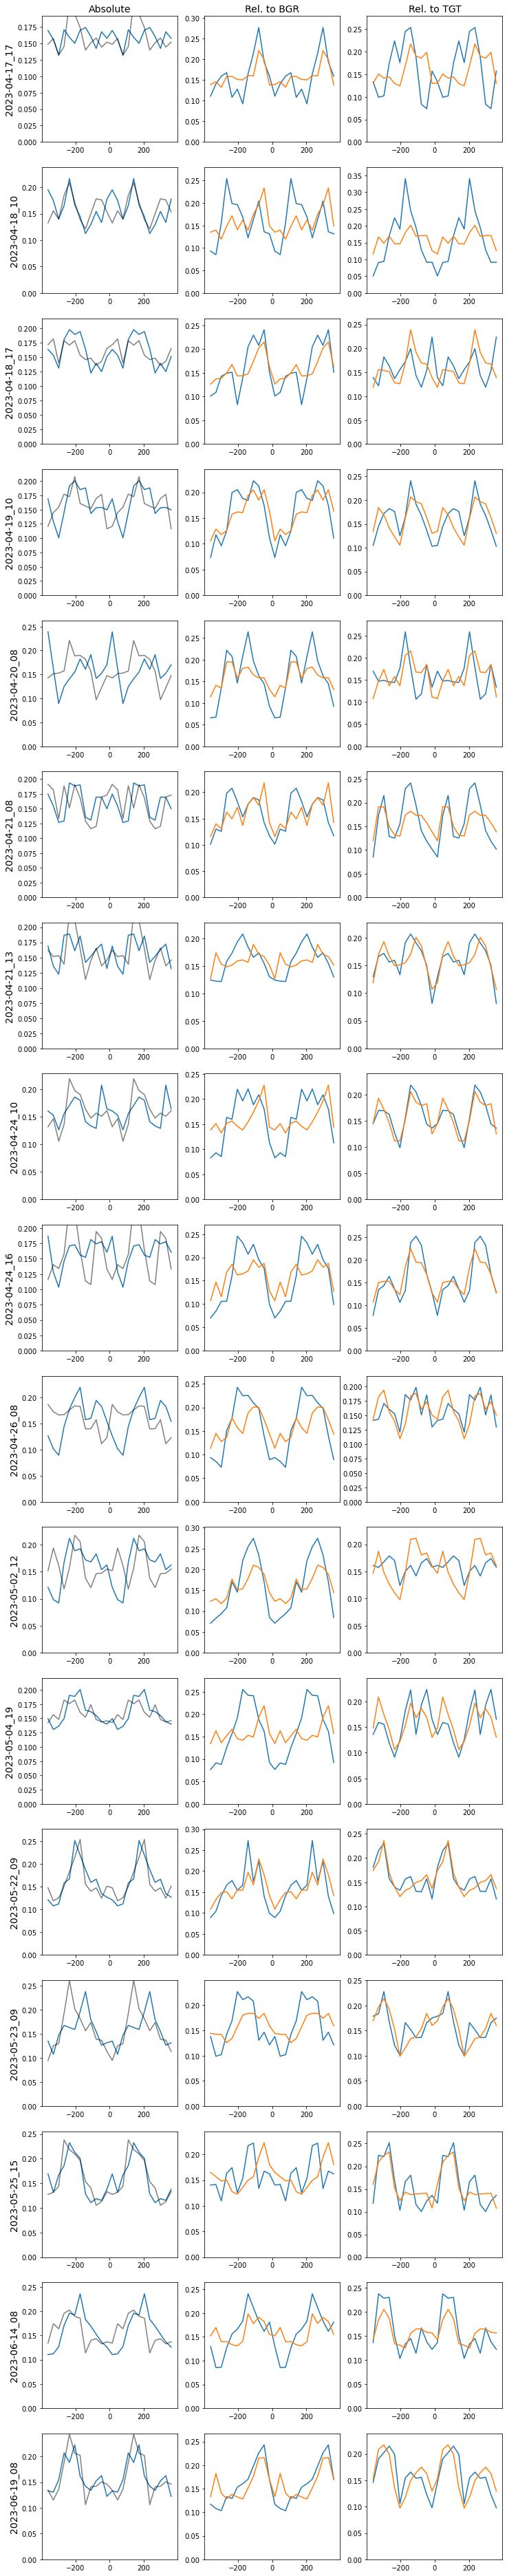

In [33]:
speaker_N  = np.array((0, 0.5))  # this one is used for BGR most of the time
speaker_SW = np.array((-0.37, -0.37))
door       = np.array((0.5, 0))

segments = 12
circ_bins = np.linspace(-np.pi, np.pi, segments+1)
bins_to_plot = np.linspace(-360, 360, 2*segments)
cols = 3
rows = len(selected)
fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))

absolutes, silence = [], []
AL_bgr, AL_tgt = [], []
PH_bgr, PH_tgt = [], []
for i, session in enumerate(selected):
    animal = session.split('_')[0]

    s_path     = os.path.join(source, animal, session)
    meta_file  = os.path.join(source, animal, session, 'meta.h5')
    desc_file  = os.path.join(source, animal, session, 'descendants.h5')
    state_file = os.path.join(source, animal, session, 'analysis', 'state_idxs.h5')
    
    with h5py.File(meta_file, 'r') as f:
        tl = np.array(f['processed']['timeline'])
        tgt_mx = np.array(f['processed']['target_matrix'])
        events = np.array(f['processed']['sound_events'])
        cfg = json.loads(f['processed'].attrs['parameters'])
    with h5py.File(desc_file, 'r') as f:
        speed = np.array(f['speed'])
        hd    = np.array(f['hd'])[:-1]
    with h5py.File(state_file, 'r') as f:
        idxs_AL_ev = np.array(f['idxs_AL_ev'])  # bAL state
        idxs_neuro_AL_bgr_ev = np.array(f['idxs_neuro_AL_bgr_ev'])
        idxs_neuro_AL_sil_ev = np.array(f['idxs_neuro_AL_sil_ev'])
        idxs_neuro_PH_bgr_ev = np.array(f['idxs_neuro_PH_bgr_ev'])
        idxs_neuro_PH_sil_ev = np.array(f['idxs_neuro_PH_sil_ev'])
        
    # HD all
    vals_bgr = np.histogram(hd[np.where(tl[:, 6] == 1)], circ_bins, density=True)[0]
    vals_sil = np.histogram(hd[np.where(tl[:, 6] == 0)], circ_bins, density=True)[0]
    
    ax = axes[i][0]
    ax.plot(bins_to_plot, np.concatenate([vals_bgr, vals_bgr]), color='tab:blue')
    ax.plot(bins_to_plot, np.concatenate([vals_sil, vals_sil]), color='black', alpha=0.5)
    ax.set_ylabel(session[-19:-6], fontsize=14)
    ax.set_ylim(0, 1.1*vals_bgr.max())
    absolutes.append(np.concatenate([vals_bgr, vals_bgr]))
    silence.append(np.concatenate([vals_sil, vals_sil]))
    
    # relative to speakers
    #idxs_AL_all = np.concatenate([idxs_neuro_AL_bgr_ev, idxs_neuro_AL_sil_ev])
    #idxs_PH_all = np.concatenate([idxs_neuro_PH_bgr_ev, idxs_neuro_PH_sil_ev])
    
    idxs_AL_all = idxs_AL_ev
    idxs_PH_all = np.array([x for x in range(len(events)) if not x in idxs_AL_ev])
    
    pos_alo = tl[:, 1:3]
    #for k, idxs_sound_state in enumerate([])
    for j, speaker in enumerate([speaker_N, speaker_SW]):
        pos_ego = get_positions_relative_to(pos_alo, hd, speaker)  # in polar coord.
        phi_ego = pos_ego[:, 1]
        phi_ego[np.where(phi_ego > np.pi)[0]] -= 2*np.pi  # tl sampling

        phi_ego_ev = np.array([phi_ego[i-10:i+10].mean() for i in events[:, 2].astype(np.int32)])

        ax = axes[i][j+1]
        v_max = 0
        for k, idxs in enumerate([idxs_AL_all, idxs_PH_all]):
            vals = np.histogram(phi_ego_ev[idxs], circ_bins, density=True)[0]
            ax.plot(bins_to_plot, np.concatenate([vals, vals]))
            if vals.max() > v_max:
                v_max = vals.max()
                
            if j == 0:
                if k == 0:
                    AL_bgr.append(np.concatenate([vals, vals]))
                else:
                    PH_bgr.append(np.concatenate([vals, vals]))
            else:
                if k == 0:
                    AL_tgt.append(np.concatenate([vals, vals]))
                else:
                    PH_tgt.append(np.concatenate([vals, vals]))
                
        ax.set_ylim(0, 1.1*v_max)

    if i == 0:
        axes[0][0].set_title('Absolute', fontsize=14)
        axes[0][1].set_title('Rel. to BGR', fontsize=14)
        axes[0][2].set_title('Rel. to TGT', fontsize=14)

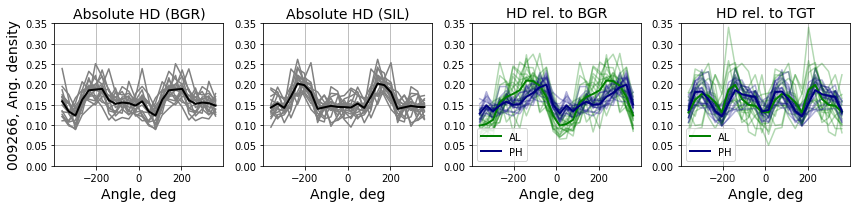

In [34]:
AL_bgr = np.array(AL_bgr)
PH_bgr = np.array(PH_bgr)
AL_tgt = np.array(AL_tgt)
PH_tgt = np.array(PH_tgt)

y_max = 0.35
titles = ['Absolute HD (BGR)', 'Absolute HD (SIL)', 'HD rel. to BGR', 'HD rel. to TGT']
fig, axes = plt.subplots(1, 4, figsize=(12, 3))

for i, profs_l in enumerate([absolutes, silence]):
    profs = np.array(profs_l)
    abs_mean = profs.mean(axis=0)
    ax = axes[i]
    #ax.set_ylim(0, 1.1*profs.max())
    ax.set_ylim(0, y_max)
    for abs_rec in profs:
        ax.plot(bins_to_plot, abs_rec, color='grey')
    ax.plot(bins_to_plot, abs_mean, color='black', lw=2)
    ax.grid()
    ax.set_title(titles[i], fontsize=14)
axes[0].set_ylabel("%s, Ang. density" % animal, fontsize=14)
    
    
ax = axes[2]
AL_bgr_mean = AL_bgr.mean(axis=0)
PH_bgr_mean = PH_bgr.mean(axis=0)
#ax.set_ylim(0, 1.1*AL_bgr.max())
ax.set_ylim(0, y_max)
for AL_rec in AL_bgr:
    ax.plot(bins_to_plot, AL_rec, color='green', alpha=0.3)
for PH_rec in PH_bgr:
    ax.plot(bins_to_plot, PH_rec, color='navy', alpha=0.3)
ax.plot(bins_to_plot, AL_bgr_mean, color='green', lw=2, label='AL')
ax.plot(bins_to_plot, PH_bgr_mean, color='navy', lw=2, label='PH')
ax.grid()
ax.legend(loc='lower left')
ax.set_title(titles[2], fontsize=14)

ax = axes[3]
AL_tgt_mean = AL_tgt.mean(axis=0)
PH_tgt_mean = PH_tgt.mean(axis=0)
#ax.set_ylim(0, 1.1*AL_tgt.max())
ax.set_ylim(0, y_max)
for AL_rec in AL_tgt:
    ax.plot(bins_to_plot, AL_rec, color='green', alpha=0.3)
for PH_rec in PH_tgt:
    ax.plot(bins_to_plot, PH_rec, color='navy', alpha=0.3)
ax.plot(bins_to_plot, AL_tgt_mean, color='green', lw=2, label='AL')
ax.plot(bins_to_plot, PH_tgt_mean, color='navy', lw=2, label='PH')
ax.grid()
ax.legend(loc='lower left')
ax.set_title(titles[3], fontsize=14)

for ax in axes:
    ax.set_xlabel('Angle, deg', fontsize=14)

fig.tight_layout()

In [35]:
fig.savefig(os.path.join(report, 'behavior', 'HD_cross_%s.png' % animal), dpi=500)